In [18]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#for catagorical features
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# import warnings
# warnings.filterwarnings("ignore")



In [145]:
df=pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# ***Data Exploration***

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


the data is clean...no Null values

In [21]:
print(f'sex : {df.sex.unique()} count : {df.sex.nunique()}')
print(f'smoker : {df.smoker.unique()} count : {df.smoker.nunique()}')
print(f'region : {df.region.unique()} count : {df.region.nunique()}')

sex : ['female' 'male'] count : 2
smoker : ['yes' 'no'] count : 2
region : ['southwest' 'southeast' 'northwest' 'northeast'] count : 4


after observing some of the categorical featuers..we can classify sex,smoker to either 0 or 1 since there is only 2
but region should be encoded by some encoder like OneHotEncoding

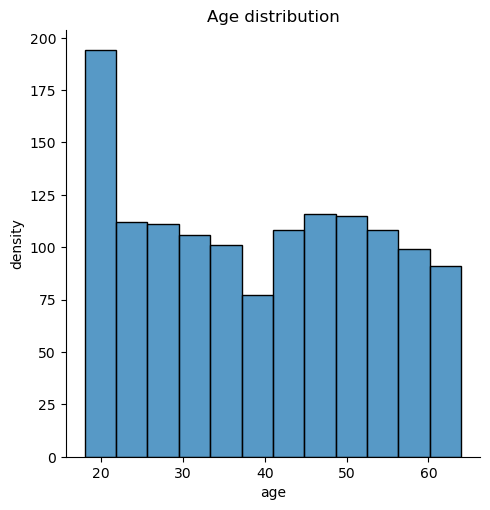

In [22]:
sns.displot(df['age'])
plt.title('Age distribution')
plt.ylabel('density')
plt.xlabel('age')
plt.show()

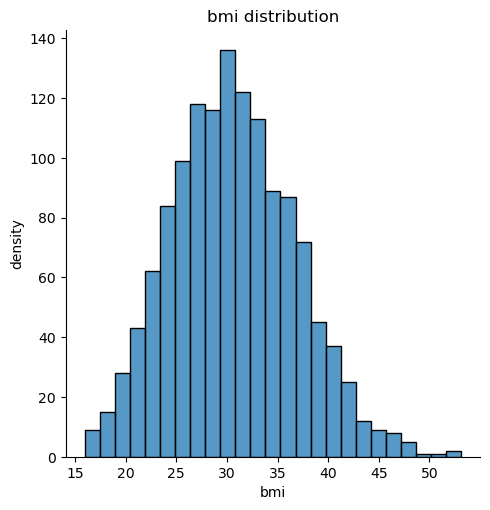

In [23]:
sns.displot(df['bmi'])
plt.title('bmi distribution')
plt.ylabel('density')
plt.xlabel('bmi')
plt.show()


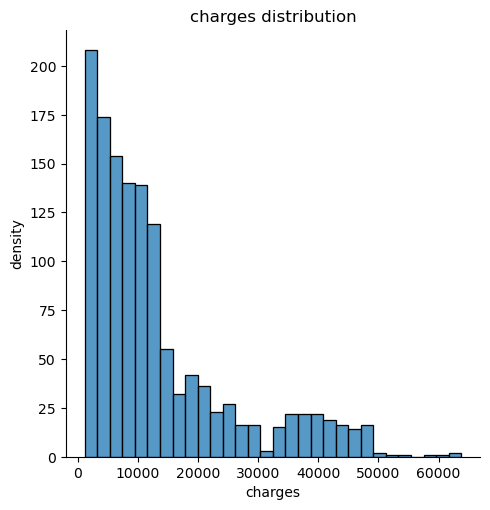

In [24]:
sns.displot(df['charges'])
plt.title('charges distribution')
plt.ylabel('density')
plt.xlabel('charges')
plt.show()


charges are skewed...this may cause some problems forward so normalization is needed
it is right-skewed. To make it closer to normal we can apply natural log


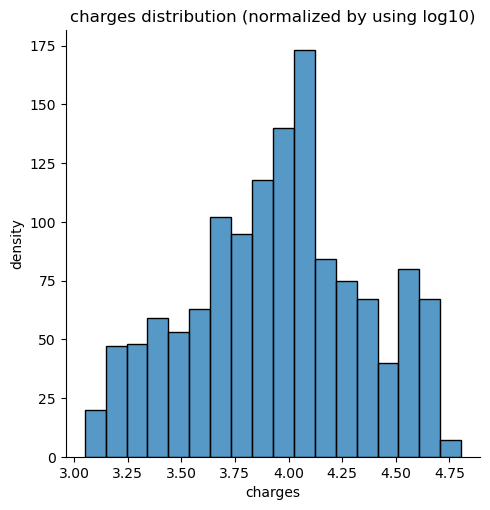

In [25]:
sns.displot(np.log10(df['charges']))
plt.title('charges distribution (normalized by using log10)')
plt.ylabel('density')
plt.xlabel('charges')
plt.show()


this looks much better!

In [49]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)


In [61]:
charges.head().index

Index(['southwest', 'northwest', 'northeast', 'southeast'], dtype='object', name='region')

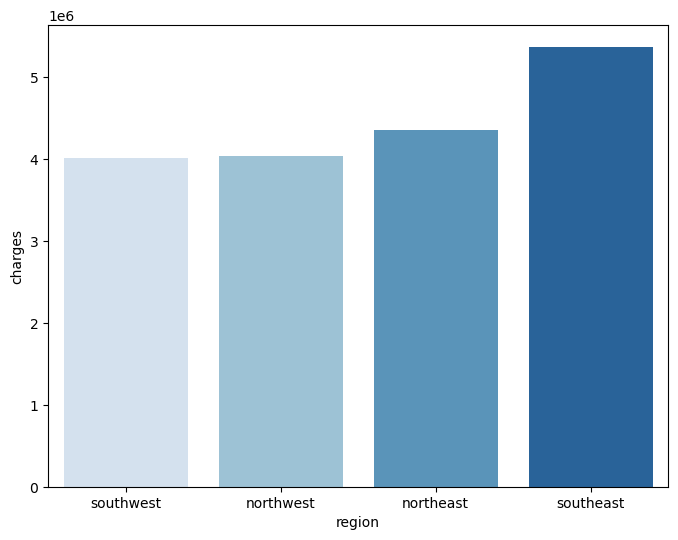

In [63]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(y=charges.head(), x=charges.head().index, palette='Blues')


the highest medical charges are in the Southeast and the lowest are in the Southwest. Now let's observe how (sex, smoking, having children) affect the charges in the regions.



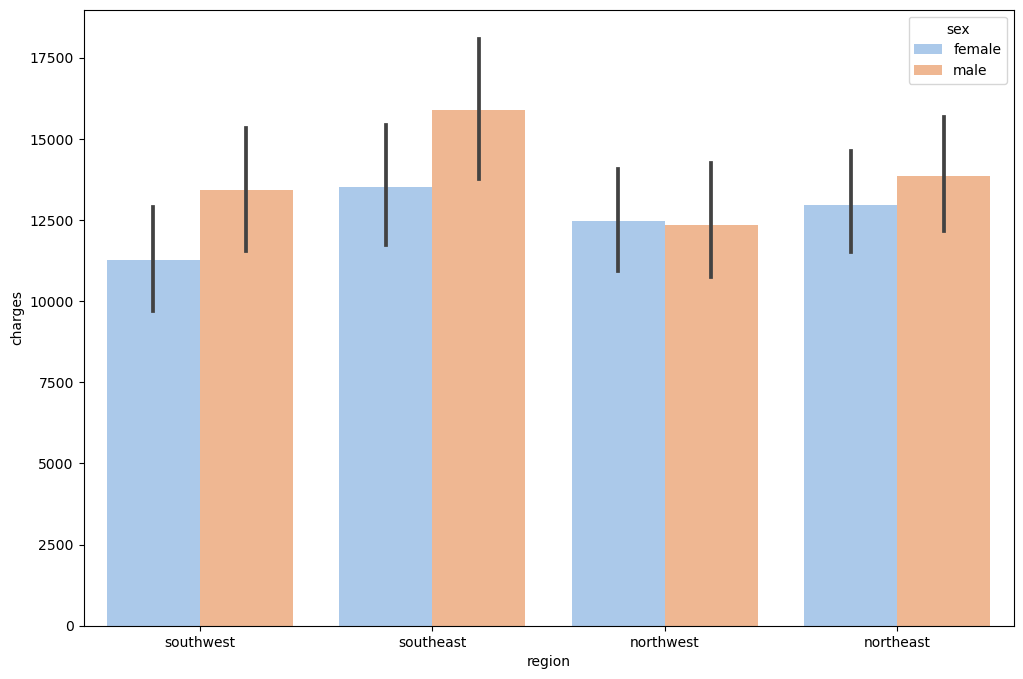

In [82]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='pastel')


the intersting thing that people in the Northeast have higher charges by gender (females pay slightly  higher than males)

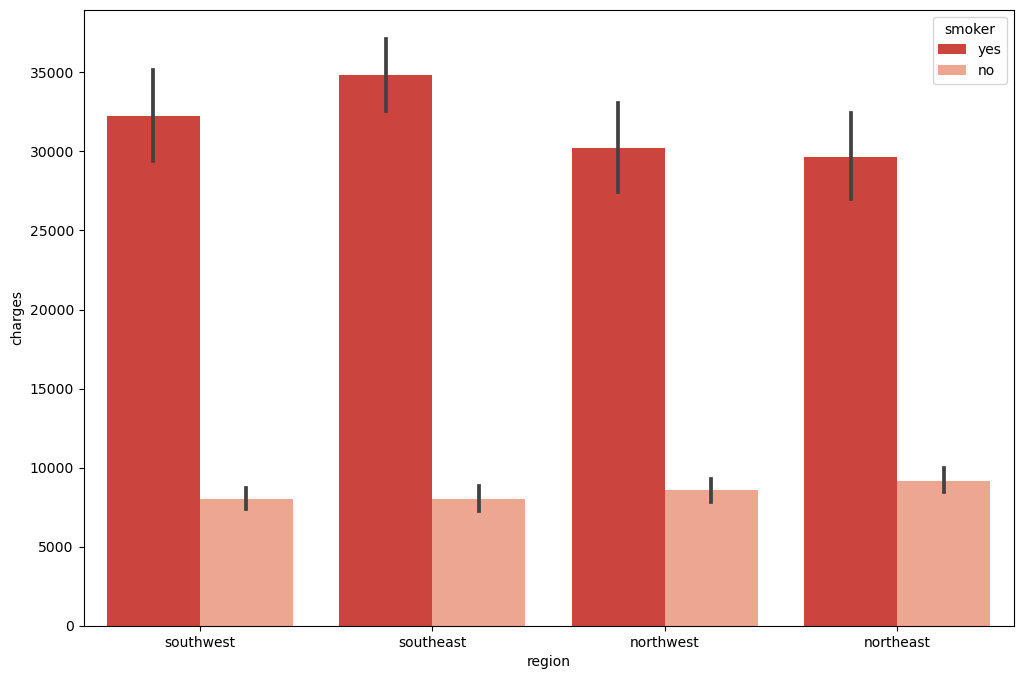

In [77]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=df, palette='Reds_r')


the highest charges due to smoking are still in the Southeast

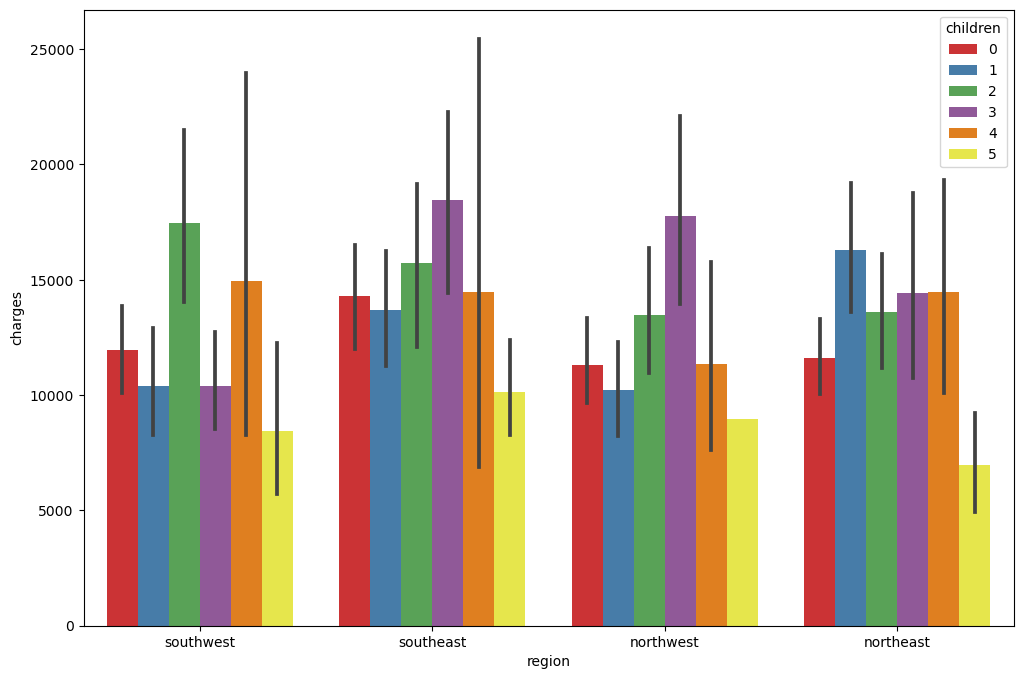

In [83]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set1')


people with children tend to have higher medical costs overall as well.



let's try and draw a regression line based on age,bmi,no.children and the charges if the person smokes or not to get an intuation about the correlation between these features.

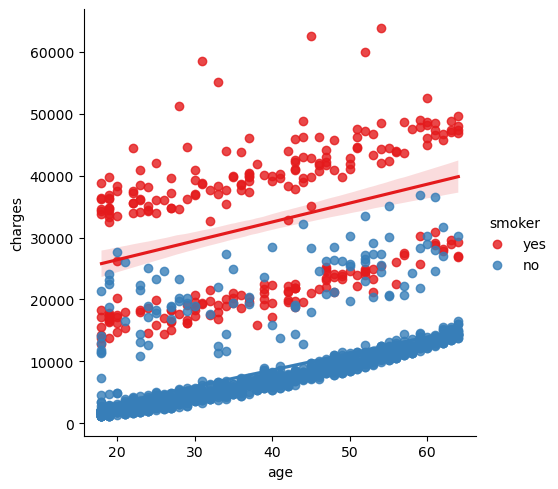

In [85]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')

being a smoker cost you more but and as shown by the red line  and blue line the relation between age and charges are positively correlated (as the age increases the charges increases)

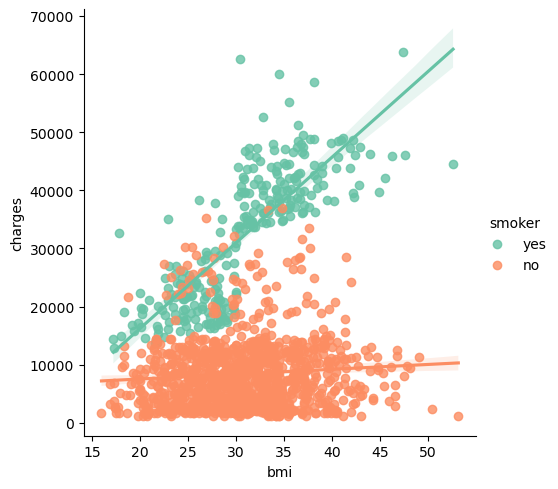

In [88]:
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')


being a smoker and having high bmi (being obese) cause you serious damage , and higher charges as shown

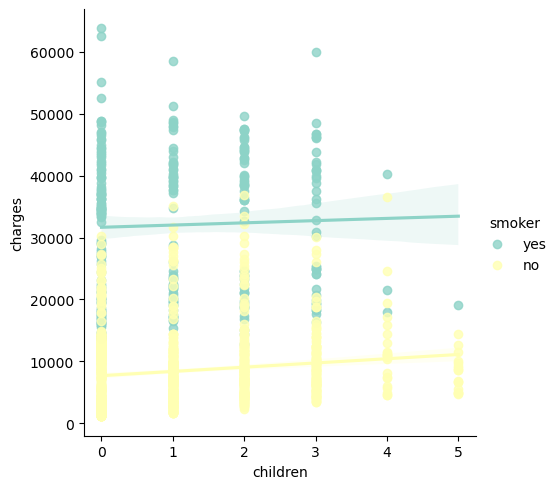

In [87]:
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')


people who have children generally smoke less

**Using violinplots to get more intuation (it's a great tool)**

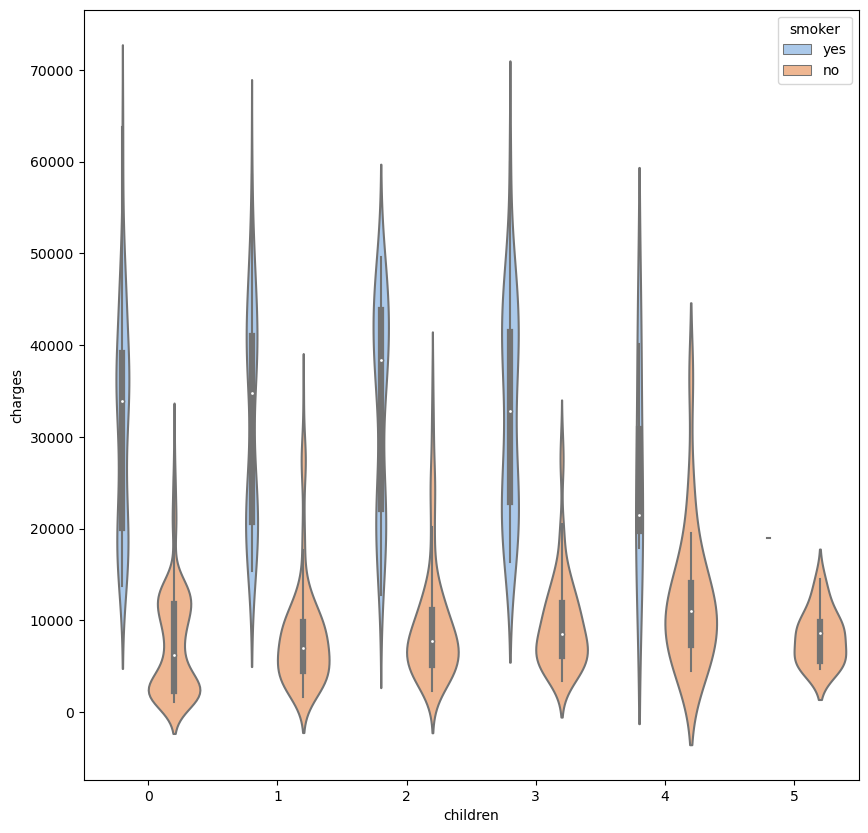

In [96]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='pastel',scale='count')


less and less people smoke when they have children but if the have alot of children like 3 for example and smoke!!! the charges skyrockets but the number of people that apply to this is very low wrt nonsmokers

In [97]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

need to convert sex,smoker,region to numerical repsentation

In [149]:
##Converting category labels into numerical using LabelEncoder,OneHotEncoder
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
def categorical_to_numerical(df):
    label = LabelEncoder()
    
    label.fit(df.sex.drop_duplicates())
    df.sex = label.transform(df.sex)
    
    label.fit(df.smoker.drop_duplicates())
    df.smoker = label.transform(df.smoker)
    
    ohe=OneHotEncoder()
    feature_arr=ohe.fit_transform(df[['region']]).toarray()
    feature_labels=np.array(ohe.categories_).ravel()
    features = pd.DataFrame(feature_arr,columns=feature_labels)
    df=df.drop(columns=['region'],axis=1)
    df=pd.concat([df,features], axis=1)
    return df

In [150]:
df=categorical_to_numerical(df)

In [151]:
df

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,0.0,1.0,0.0,0.0
1334,18,0,31.920,0,0,2205.98080,1.0,0.0,0.0,0.0
1335,18,0,36.850,0,0,1629.83350,0.0,0.0,1.0,0.0
1336,21,0,25.800,0,0,2007.94500,0.0,0.0,0.0,1.0


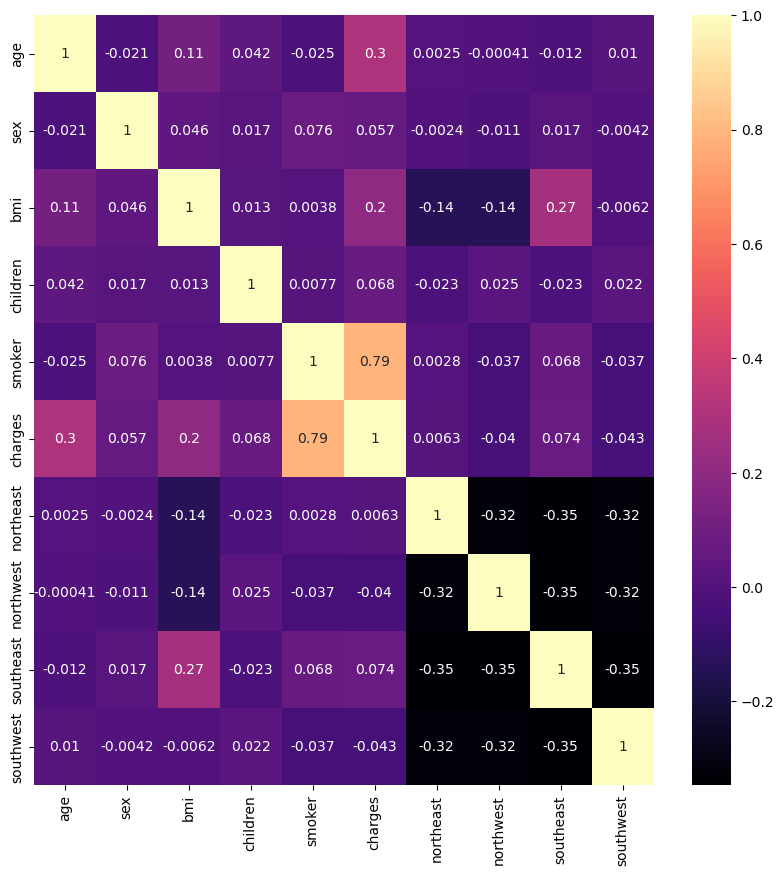

In [168]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap="magma")


smoker has the highest correlation with charges =0.79

# Modeling

# *1-Linear Regression*

In [172]:
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
x = df.drop(['charges'], axis = 1)
y = df['charges']
x_train, x_test, y_train, y_test = split(x, y, test_size=0.2, random_state=0)
Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)
#y=ax+b
print(f'b = : {Lin_reg.intercept_}')
print(f'a = :{Lin_reg.coef_}')
#the coefficient of determination r2
#R-Squared is a statistical measure of fit that indicates 
#how much variation of a dependent variable is explained by the independent variable(s) 
#in a regression model.

print(Lin_reg.score(x_test, y_test))

b = : -12311.913605650452
a = :[ 2.53700500e+02 -1.54637279e+01  3.35962814e+02  4.36910121e+02
  2.36050173e+04  4.83840068e+02  2.23707336e+02 -4.29438766e+02
 -2.78108638e+02]
0.7999876970680433


# 2-Random Forest Regressor


In [277]:
from sklearn.ensemble import RandomForestRegressor
Rfr = RandomForestRegressor(n_estimators = 100, criterion = 'mse',
                              random_state = 14,
                              n_jobs = -1)
Rfr.fit(x_train,y_train)
x_train_pred = Rfr.predict(x_train)
x_test_pred = Rfr.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % 
      (metrics.mean_squared_error(x_train_pred, y_train),
       metrics.mean_squared_error(x_test_pred, y_test)))
print('R2 train data: %.3f, R2 test data: %.3f' % 
      (metrics.r2_score(x_train_pred, y_train),
       metrics.r2_score(x_test_pred, y_test)))

MSE train data: 3696689.034, MSE test data: 21696625.610
R2 train data: 0.972, R2 test data: 0.857


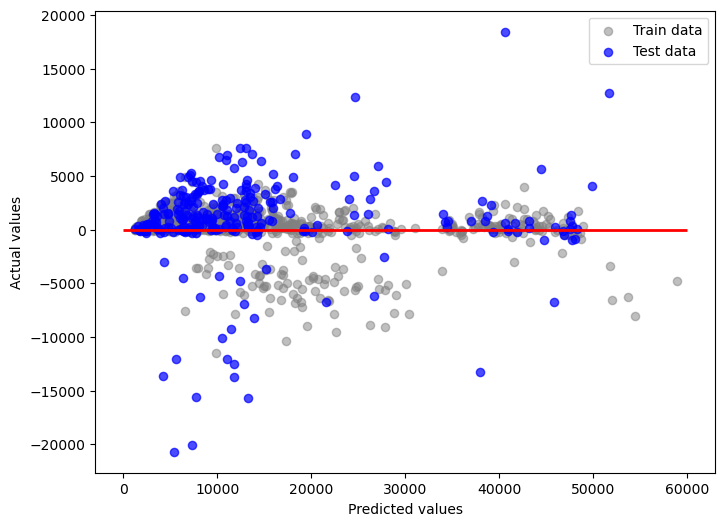

In [176]:
plt.figure(figsize=(8,6))

plt.scatter(x_train_pred, x_train_pred - y_train,
          c = 'gray', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(x_test_pred, x_test_pred - y_test,
          c = 'blue', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')

seems like a good fit but hyperparameter tunning can also result in a better peformance

In [272]:
n_estimators = range(50,250,1) # number of trees in the random forest
random_grid = {'n_estimators': n_estimators,
              }

In [278]:
from sklearn.model_selection import GridSearchCV
rf_random = GridSearchCV(estimator = RandomForestRegressor(random_state=14),param_grid = random_grid,
              cv = 5, verbose=2, n_jobs = -1,scoring='r2',return_train_score=True)


In [279]:
rf_random.fit(x_train, y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits

[CV] END ...................................n_estimators=220; total time=   1.3s
[CV] END ...................................n_estimators=220; total time=   1.3s
[CV] END ...................................n_estimators=221; total time=   1.3s
[CV] END ...................................n_estimators=221; total time=   1.3s
[CV] END ...................................n_estimators=221; total time=   1.3s
[CV] END ...................................n_estimators=222; total time=   2.6s
[CV] END ...................................n_estimators=222; total time=   1.3s
[CV] END ...................................n_estimators=223; total time=   1.3s
[CV] END ...................................n_estimators=223; total time=   1.3s
[CV] END ...................................n_estimators=223; total time=   1.3s
[CV] END ...................................n_estimators=224; total time=   1.3s
[CV] END ...................................

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=14), n_jobs=-1,
             param_grid={'n_estimators': range(50, 250)},
             return_train_score=True, scoring='r2', verbose=2)

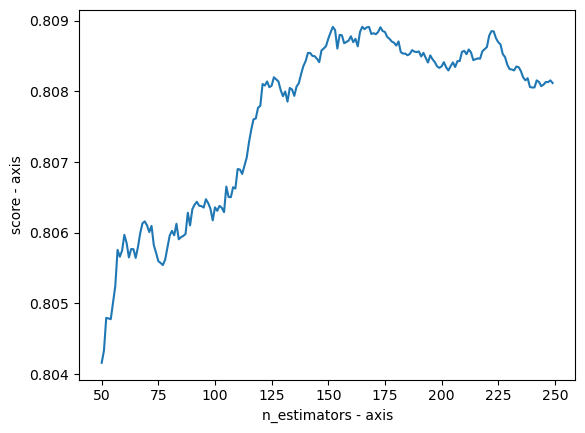

In [280]:
plt.plot(list(n_estimators), rf_random.cv_results_['mean_test_score'])
plt.xlabel('n_estimators - axis')
plt.ylabel('score - axis')
plt.show()


In [281]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': range(50, 250)} 

Best Parameters:  {'n_estimators': 165}  



In [282]:
from sklearn.ensemble import RandomForestRegressor
Rfr = RandomForestRegressor(n_estimators = rf_random.best_params_['n_estimators'], criterion = 'mse',
                              random_state = 14,
                              n_jobs = -1)
Rfr.fit(x_train,y_train)
x_train_pred = Rfr.predict(x_train)
x_test_pred = Rfr.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % 
      (metrics.mean_squared_error(x_train_pred, y_train),
       metrics.mean_squared_error(x_test_pred, y_test)))
print('R2 train data: %.3f, R2 test data: %.3f' % 
      (metrics.r2_score(x_train_pred, y_train),
       metrics.r2_score(x_test_pred, y_test)))


MSE train data: 3754787.618, MSE test data: 21408643.503
R2 train data: 0.971, R2 test data: 0.859


now it peforms slightly better

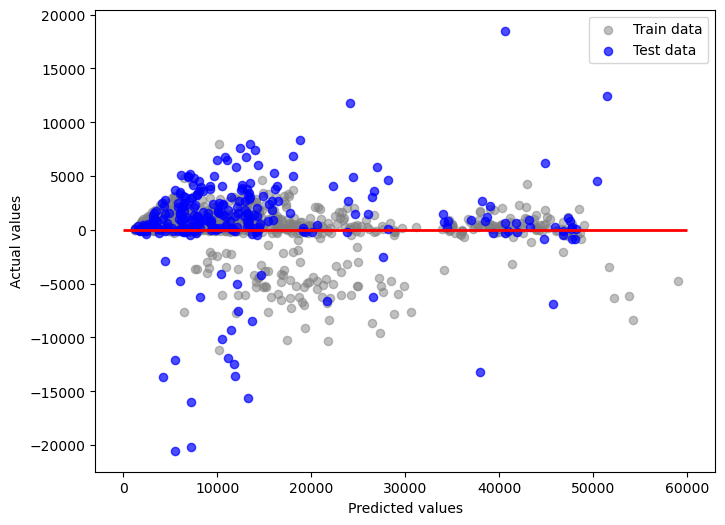

In [237]:
plt.figure(figsize=(8,6))

plt.scatter(x_train_pred, x_train_pred - y_train,
          c = 'gray', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(x_test_pred, x_test_pred - y_test,
          c = 'blue', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')

# 3-Polynomial Regression

In [247]:
from sklearn.preprocessing import PolynomialFeatures
x = df.drop(['charges', 'sex','southwest', 'northwest', 'northeast', 'southeast'], axis = 1)
y = df.charges
pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(x)
x_train, x_test, y_train, y_test = split(x_pol, y, test_size=0.2, random_state=0)


Pol_reg = LinearRegression()
Pol_reg.fit(x_train, y_train)
y_train_pred = Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)
print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(x_test, y_test))


-5325.881705252277
[ 0.00000000e+00 -4.01606591e+01  5.23702019e+02  8.52025026e+02
 -9.52698471e+03  3.04430186e+00  1.84508369e+00  6.01720286e+00
  4.20849790e+00 -9.38983382e+00  3.81612289e+00  1.40840670e+03
 -1.45982790e+02 -4.46151855e+02 -9.52698471e+03]
0.8812595703345228


dropped ['charges', 'sex','southwest', 'northwest', 'northeast', 'southeast'] because they had very small effect on charges so dropping them actually increased the accuarcy of the model

# 4-Gradient Boosting Regressor Model

In [254]:
Gradient_model = GradientBoostingRegressor()
Gradient_model.fit(x_train, y_train)

y_train_pred = Gradient_model.predict(x_train)
y_test_pred = Gradient_model.predict(x_test)

print(Gradient_model.score(x_test, y_test))

print('R2 train data: %.3f, R2 test data: %.3f' % 
      (metrics.r2_score(y_train_pred, y_train),
       metrics.r2_score(y_test_pred, y_test)))


0.8905381191171967
R2 train data: 0.896, R2 test data: 0.883


peforming some hyperparameter tunning on n-estimators

In [255]:
gbr = GridSearchCV(estimator = GradientBoostingRegressor(),param_grid = random_grid,
              cv = 5, verbose=2, n_jobs = -1,scoring='r2',return_train_score=True)

In [256]:
gbr.fit(x_train, y_train)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=51; total time=   0.1s
[CV] END ....................................n_estimators=51; total time=   0.1s
[CV] END ....................................n_estimators=51; total time=   0.1s
[CV] END ....................................n_estimators=52; total time=   0.1s
[CV] END ....................................n_estimators=52; total time=   0.1s
[CV] END ....................................n_estimators=53; total time=   0.1s
[CV] END ....................................n_estimators=53; total time=   0.1s
[CV] END ....................................n_estimators=53; total time=   0.1s
[CV] END ....................................n_estimators=54; total time=   0.1s
[CV] END ....................................

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'n_estimators': range(50, 250)},
             return_train_score=True, scoring='r2', verbose=2)

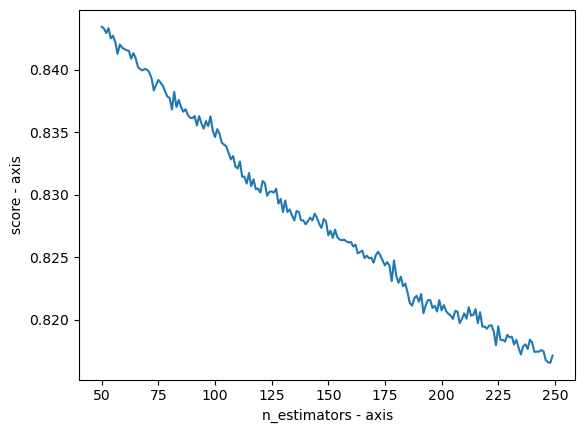

In [265]:
plt.plot(list(n_estimators), gbr.cv_results_['mean_test_score'])
plt.xlabel('n_estimators - axis')
plt.ylabel('score - axis')
plt.show()

In [258]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', gbr.best_params_, ' \n')

Random grid:  {'n_estimators': range(50, 250)} 

Best Parameters:  {'n_estimators': 50}  



In [263]:
Gradient_model = GradientBoostingRegressor(n_estimators=gbr.best_params_['n_estimators'])
Gradient_model.fit(x_train, y_train)

y_train_pred = Gradient_model.predict(x_train)
y_test_pred = Gradient_model.predict(x_test)

print(Gradient_model.score(x_test, y_test))

print('R2 train data: %.3f, R2 test data: %.3f' % 
      (metrics.r2_score(y_train_pred, y_train),
       metrics.r2_score(y_test_pred, y_test)))


0.8913194298431769
R2 train data: 0.865, R2 test data: 0.881
